<a href="https://colab.research.google.com/github/Haimonti/CarePathways/blob/main/GCN_9_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install  dgl -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 41.2 MB/s eta 0:00:00


In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


In [3]:
pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 724.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 34.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=f597cd10df68bc3ff3fdc872cb4e4dc6e2ee8b60d41c243294fcced52d2fa380
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf

In [4]:
import optuna
from optuna.trial import TrialState

In [5]:
import numpy as np

In [6]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/someTest.csv")
df.shape

Mounted at /content/drive


(145598, 3)

In [7]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
from dgl.data import DGLDataset
from dgl.data import CSVDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

class CarePathwaysDataset(DGLDataset):

        def __init__(self):
          super().__init__(name="care_pthways")

        def process(self):
          nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4.csv")
          print(nodes_data.shape)
          #Attribute names
          print(nodes_data.columns)
          node_feat = nodes_data.drop(['id','Mean HLOS'], axis=1)
          print(f"Node Features Dimension {node_feat.shape}")
          tsr_feat = torch. tensor(node_feat.values)
          torch.save(tsr_feat, 'data.pt')

          edges_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/someTest.csv")
          #node_features = torch.from_numpy(nodes_data["age"].to_numpy())
          node_features = tsr_feat
          node_labels = torch.from_numpy(nodes_data["Mean HLOS"].astype(float).to_numpy())
          edge_features = torch.from_numpy(edges_data["Weight"].to_numpy())
          edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
          edges_dst = torch.from_numpy(edges_data["Dst"].to_numpy())

          self.graph = dgl.graph((edges_src, edges_dst),num_nodes=nodes_data.shape[0])
          self.graph.ndata["feat"] = node_features
          self.graph.ndata["label"] = node_labels
          self.graph.edata["weight"] = edge_features

           # If your dataset is a node classification dataset, you will need to assign
          # masks indicating whether a node belongs to training, validation, and test set.
          n_nodes = nodes_data.shape[0]
          n_train = int(n_nodes * 0.6)
          #train_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTrainInd.csv")
          n_val = int(n_nodes * 0.2)
          #val_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptValidInd.csv")
          n_test = 100
          #test_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTestInd.csv")
          train_mask = torch.zeros(n_nodes, dtype=torch.int)
          val_mask = torch.zeros(n_nodes, dtype=torch.int)
          test_mask = torch.zeros(n_nodes, dtype=torch.int)
          train_mask[:n_train] = int(1)
          val_mask[n_train : n_train + n_val] = int(1)
          test_mask[n_train + n_val :] = int(1)
          self.graph.ndata["train_mask"] = train_mask
          self.graph.ndata["val_mask"] = val_mask
          self.graph.ndata["test_mask"] = test_mask

        def __getitem__(self, i):
          return self.graph

        def __len__(self):
          return 1

dataset = CarePathwaysDataset()
g = dataset[0]
print(g)

# Gather statistics from the graph
print(f"Number of nodes {g.num_nodes}")
print(f"Number of edges {g.num_edges}")
#print(f"Average node degree {g.num_edges / g.num_nodes}")
#print(f"Number of training nodes {train_mask.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(508, 45)
Index(['id', 'admission_disposition', 'age', 'sex', 'Hypertension',
       'Chronic cardiac disease (not hypertension)', 'N/A', 'Diabetes',
       'History of cancer [now in remission]', 'Other', 'Kidney disease',
       'Obesity', 'Asthma', 'Rheumatologic disorder',
       'Dementia [any etiology]', 'Chronic pulmonary (lung) disease',
       'Pregnancy', 'Stroke', 'Cancer [active only]', 'Liver disease',
       'Chronic renal', 'Chronic neurological disorder', 'Hematological',
       'reason_for_admission_ARDS (adult respiratory distress syndrome) [J80]',
       'reason_for_admission_Acquired respiratory distress syndrome [J80]',
       'reason_for_admission_COVID-19 [U07.1]',
       'reason_for_admission_COVID-19 determined by clinical diagnostic criteria [U07.2]',
       'reason_for_admission_COVID-19 virus infection [U07.1]',
       'reason_for_

In [8]:
nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4_reg.csv")
nodes_data['Unnamed: 0']

0        0
1        1
2        2
3        3
4        4
      ... 
503    503
504    504
505    505
506    506
507    507
Name: Unnamed: 0, Length: 508, dtype: int64

In [9]:
class CarePathwaysDataset_reg(DGLDataset):

        def __init__(self):
          super().__init__(name="care_pthways")

        def process(self):
          nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4_reg.csv")
          print(nodes_data.shape)
          #Attribute names
          print(nodes_data.columns)
          node_feat = nodes_data.drop(['id','Hospital LOS', 'Std Dev','Unnamed: 0','comorbidities_other','Mean HLOS'], axis=1) #LOS and std dev
          print(f"Node Features Dimension {node_feat.shape}")
          tsr_feat = torch. tensor(node_feat.values)
          torch.save(tsr_feat, 'data.pt')

          edges_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/someTest.csv")
          #node_features = torch.from_numpy(nodes_data["age"].to_numpy())
          node_features = tsr_feat
          node_labels = torch.from_numpy(nodes_data["Hospital LOS"].astype(float).to_numpy()) #LOS
          edge_features = torch.from_numpy(edges_data["Weight"].to_numpy())
          edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
          edges_dst = torch.from_numpy(edges_data["Dst"].to_numpy())

          self.graph = dgl.graph((edges_src, edges_dst),num_nodes=nodes_data.shape[0])
          self.graph.ndata["feat"] = node_features
          self.graph.ndata["label"] = node_labels
          self.graph.edata["weight"] = edge_features

           # If your dataset is a node classification dataset, you will need to assign
          # masks indicating whether a node belongs to training, validation, and test set.
          n_nodes = nodes_data.shape[0]
          n_train = int(n_nodes * 0.6)
          #train_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTrainInd.csv")
          n_val = int(n_nodes * 0.2)
          #val_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptValidInd.csv")
          n_test = 100
          #test_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTestInd.csv")

          train_mask = torch.zeros(n_nodes, dtype=torch.int)
          val_mask = torch.zeros(n_nodes, dtype=torch.int)
          test_mask = torch.zeros(n_nodes, dtype=torch.int)
          train_mask[:n_train] = int(1)
          val_mask[n_train : n_train + n_val] = int(1)
          test_mask[n_train + n_val :] = int(1)
          #self.graph.ndata["train_mask"] = node_labels[:n_train]       #train_mask
          #self.graph.ndata["val_mask"] =   node_labels[n_train : n_train + n_val]      #val_mask
          #self.graph.ndata["test_mask"] =  node_labels[n_train + n_val :]    #test_mask

        def __getitem__(self, i):
          return self.graph

        def __len__(self):
          return 1
dataset_reg = CarePathwaysDataset_reg()
gg = dataset_reg[0]
print(gg)

# Gather statistics from the graph
print(f"Number of nodes {gg.num_nodes}")
print(f"Number of edges {gg.num_edges}")
#print(f"Average node degree {g.num_edges / g.num_nodes}")
#print(f"Number of training nodes {train_mask.shape}")

(508, 55)
Index(['Unnamed: 0', 'id', 'admission_disposition', 'age', 'sex',
       'Hospital LOS', 'Std Dev', 'Hypertension',
       'Chronic cardiac disease (not hypertension)', 'N/A', 'Diabetes',
       'History of cancer [now in remission]', 'Other', 'Kidney disease',
       'Obesity', 'Asthma', 'Rheumatologic disorder',
       'Dementia [any etiology]', 'Chronic pulmonary (lung) disease',
       'Pregnancy', 'Stroke', 'Cancer [active only]', 'Liver disease',
       'Chronic renal', 'Chronic neurological disorder', 'Hematological',
       'comorbidities_other', 'Mean HLOS',
       'reason_for_admission_ARDS (adult respiratory distress syndrome) [J80]',
       'reason_for_admission_Acquired respiratory distress syndrome [J80]',
       'reason_for_admission_Atypical pneumonia [J18.9]',
       'reason_for_admission_COVID-19 [U07.1]',
       'reason_for_admission_COVID-19 determined by clinical diagnostic criteria [U07.2]',
       'reason_for_admission_COVID-19 virus infection [U07.1]',

In [10]:
#gg.ndata['label'][gg.ndata['test_mask']]

In [11]:
# Training a Multilayer Perceptron (MLP)
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
  def __init__(self, hidden_channels):
      super().__init__()
      #torch.manual.seed(12113)
      self.lin1 = Linear(43, hidden_channels)
      self.lin2 = Linear(hidden_channels, 2)

  def forward(self,x):
      x = self.lin1(x)
      #x = x.relu()
      x = x.sigmoid()
      x = self.lin2(x)
      return x

#train_data_sz = 422
#modelMLP = MLP(train_data_sz, hidden_channels=16)
#print(modelMLP)

In [27]:
import numpy as np
import torch
from torch.nn import Linear

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

#No GNNs involved -- simply run MLP on the data
nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4.csv")
#print(nodes_data.shape)
#Attribute names
#print(nodes_data.columns)
node_feat = nodes_data.drop(['id','Mean HLOS'], axis=1)
print(f"Node features dimension: {node_feat.shape}")
tsr_feat = torch.tensor(node_feat.values)
tsr_feat = tsr_feat.to(torch.float32)
labels = torch.from_numpy(nodes_data["Mean HLOS"].astype(float).to_numpy())

#Split the data into train and test
n_data_sz = nodes_data.shape[0]
msk = np.random.rand(n_data_sz) < 0.8
#print(f"Mask {msk}")
nodes_data_train = tsr_feat[msk]
print(f"Size of training data {nodes_data_train.shape}")
nodes_data_test = tsr_feat[~msk]
print(f"Size of test data {nodes_data_test.shape}")

modelMLP = MLP(hidden_channels=16)
print(f"Model is: {modelMLP}")
#mdl = Linear(node_feat.shape[1], 2, bias=False)
#Define loss criterion
criterion = torch.nn.CrossEntropyLoss()
#Define optimizer
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=0.01, weight_decay=5e-4)

def train():
       optimizer.zero_grad()
       #print(f"Data type of model weight {mdl.weight.dtype}")
       #print(f"Dimension of model weight - first {modelMLP.lin1.weight.shape}")
       #print(f"Dimension of model weight - sec {modelMLP.lin2.weight.shape}")
       #print(f"Data type of the features {nodes_data_train.dtype}")
       #out = mdl(nodes_data_train)
       out = modelMLP(nodes_data_train)
       #print(out.size())
       #print(out.dtype)
       #print(labels[msk].dtype)
       #Check out the actual predictions
       #print(f"What is out? {out}")

       #Assume model is built on the entire dataset
       loss = criterion(out,labels[msk].to(torch.long))
       #print(f"Loss is {loss}")
       #val_loss = criterion(out["val_mask"],labels["val_mask"])
       loss.backward()
       optimizer.step()
       return loss

def test():
      #mdl.eval()
      modelMLP.eval()
      #outMLP = mdl(nodes_data_test)
      outMLP = modelMLP(nodes_data_test)
      pred = outMLP.argmax(dim=1)
      test_correct = pred == labels[~msk]
      test_acc = int(test_correct.sum()) / int(nodes_data_test.shape[0])
      return test_acc

for epoch in range (1, 10):
     loss_tr = train()
     test_acc = test()
     print(f"Epoch: {epoch: 1d}, Loss: {loss_tr: 0.4f}, Test Acc. {test_acc: 0.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Node features dimension: (508, 43)
Size of training data torch.Size([391, 43])
Size of test data torch.Size([117, 43])
Model is: MLP(
  (lin1): Linear(in_features=43, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)
Epoch:  1, Loss:  0.7887, Test Acc.  0.2906
Epoch:  2, Loss:  0.7212, Test Acc.  0.7094
Epoch:  3, Loss:  0.6722, Test Acc.  0.7094
Epoch:  4, Loss:  0.6403, Test Acc.  0.7094
Epoch:  5, Loss:  0.6231, Test Acc.  0.7094
Epoch:  6, Loss:  0.6187, Test Acc.  0.7094
Epoch:  7, Loss:  0.6234, Test Acc.  0.7094
Epoch:  8, Loss:  0.6303, Test Acc.  0.7094
Epoch:  9, Loss:  0.6351, Test Acc.  0.7094


In [14]:
def define_model(trial):
  n_layers = trial.suggest_int("n_layers", 1, 3)
  layers = []
  in_feats= g.ndata["feat"].shape[1]
  for i in range(n_layers):
    out_feats = trial.suggest_int("n_units_l{}".format(i), 4, 128)
    layers.append(GraphConv(in_feats, out_feats))
    layers.append(nn.ReLU())
    p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
    layers.append(nn.Dropout(p))

    in_feats=out_feats
  layers.append(GraphConv(in_feats, 2))
  layers.append(nn.LogSoftmax(dim=1))
  return nn.Sequential(*layers)

In [152]:
def train(g, model):
      #Select the Adam optimizer for no apparent reason
      optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
      best_val_acc = 0
      best_test_acc = 0

      features = g.ndata["feat"]
      ##print(f"Features are: {features}")
      labels = g.ndata["label"]
      #print(f"Labels are: {labels}")
      train_mask = g.ndata["train_mask"]
      #print(f"Train_mask {train_mask}")
      val_mask = g.ndata["val_mask"]
      test_mask = g.ndata["test_mask"]

      for e in range(100):
        # Forward
        logits = model(g, features)
        #print(f"Prediction is {logits}")
        # Compute prediction
        #logits=g.ndata["feat"]
        pred = logits.argmax(dim=1) #change it to = logits
        #print(pred[train_mask])
        #print(f"Prediction is {pred}")

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        #print(f"Data type {logits[train_mask].dtype}")
        #print(f"Data type {labels[train_mask].dtype}")
        loss = F.cross_entropy(logits[train_mask], labels[train_mask].to(torch.long))
        #print(f"Loss is {loss}")

        # Compute accuracy on training/validation/test #change it to mse
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 25 == 0:
            print(
                f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
            )
      return best_val_acc, best_test_acc


# Create the model with given dimensions
model = GCN(43,32, 2)
#print(model)
train(g,model)
#train= (CarePatethwayDataset(df)[0],GCN(43,32,2))

In epoch 0, loss: 0.975, val acc: 0.801 (best 0.801), test acc: 0.797 (best 0.797)
In epoch 25, loss: 0.662, val acc: 0.199 (best 0.801), test acc: 0.203 (best 0.797)
In epoch 50, loss: 0.651, val acc: 0.199 (best 0.801), test acc: 0.203 (best 0.797)
In epoch 75, loss: 0.636, val acc: 0.199 (best 0.801), test acc: 0.203 (best 0.797)


(tensor(0.8012), tensor(0.7972))

In [16]:
#best_pred_array=[]
def train_reg(g, model):
      #Select the Adam optimizer for no apparent reaspon
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
      best_val_acc = np.inf
      best_test_acc = np.inf
      best_pred_array=[]

      features = g.ndata["feat"]
      print(f"Features are: {features}")
      labels = g.ndata["label"]  #change it to length of stay

      #print(f"Labels are: {labels}")
      n_nodes = nodes_data.shape[0]
      n_train = int(n_nodes * 0.6)
      n_val = int(n_nodes * 0.2)
      n_test = 100
      train_mask = labels[:n_train]
      #print(f"Train_mask {train_mask}")
      val_mask = labels[n_train : n_train + n_val]
      test_mask = labels[n_train + n_val :]

      for e in range(50): #50
        # Forward
        logits = model(g, features)
        #print(f"Prediction is {logits}")
        # Compute prediction
        #logits=g.ndata["feat"]
        pred = logits #logits.argmax(dim=1)
        #print(pred[train_mask])
        #print(f"Prediction is {pred}")

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        #print(f"Data type {logits[train_mask].dtype}")
        #print(f"Data type {labels[train_mask].dtype}")

        #loss = F.cross_entropy(logits[train_mask], labels[train_mask].to(torch.long))
        logits=logits.flatten()
        maeloss=torch.nn.L1Loss()
        loss=maeloss(logits[:n_train], train_mask.to(torch.long))
        #print(logits[train_mask])
        #print(labels[train_mask])
        #print(f"Loss is {loss}")

        # Compute accuracy on training/validation/test
        train_acc = ((pred[:n_train] - train_mask).float()**2).mean() #(pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = ((pred[n_train : n_train + n_val] - val_mask).float()**2).mean() #(pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = ((pred[n_train + n_val :] - test_mask).float()**2).mean() #(pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc > val_acc: #if the MSE is smaller
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_pred_array=pred[n_train + n_val :]

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
                f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
            )
      return best_pred_array


# Create the model with given dimensions
model_reg = GCN(gg.ndata["feat"].shape[1],10, 1)
#print(model)
b=train_reg(gg,model_reg)

Features are: tensor([[ 1, 74,  1,  ...,  0,  0,  0],
        [ 1, 61,  0,  ...,  0,  0,  0],
        [ 1, 58,  0,  ...,  0,  0,  0],
        ...,
        [ 1, 74,  1,  ...,  0,  0,  0],
        [ 1, 48,  0,  ...,  0,  0,  0],
        [ 1, 73,  1,  ...,  0,  0,  0]])
In epoch 0, loss: 12.634, val acc: 360.714 (best 360.714), test acc: 196.039 (best 196.039)
In epoch 5, loss: 7.570, val acc: 177.773 (best 177.773), test acc: 82.870 (best 82.870)
In epoch 10, loss: 8.452, val acc: 159.697 (best 159.697), test acc: 91.409 (best 91.409)
In epoch 15, loss: 7.677, val acc: 171.423 (best 159.697), test acc: 82.563 (best 91.409)
In epoch 20, loss: 7.680, val acc: 203.293 (best 159.697), test acc: 91.316 (best 91.409)
In epoch 25, loss: 7.646, val acc: 200.917 (best 159.697), test acc: 90.257 (best 91.409)
In epoch 30, loss: 7.548, val acc: 179.951 (best 159.697), test acc: 83.239 (best 91.409)
In epoch 35, loss: 7.590, val acc: 176.145 (best 159.697), test acc: 82.686 (best 91.409)
In epoch 40

In [17]:
len(gg.ndata['label'])

508

In [18]:
b.flatten()

tensor([10.6630, 11.1559, 12.6532, 13.7424, 13.1016, 11.1560,  5.5366, 15.0295,
        10.4750, 14.2100,  9.6868, 11.1043, 13.8733, 14.3698, 15.0020, 14.0112,
         7.1102, 15.0020, 14.8573, 14.2100, 14.3698, 12.6532, 11.1559, 10.6630,
        13.3713, 14.8505, 12.0616, 14.0289, 14.7345, 15.0295, 14.2100, 15.3051,
        12.5058, 13.7424, 12.0149, 12.4835, 12.9450, 15.1983, 12.9450, 14.8573,
        15.0020, 14.3698, 14.7345, 11.1043, 14.7777, 14.8111, 10.6630, 11.3145,
        14.7345, 14.8573, 14.8505, 12.9566, 14.7345, 12.4835, 15.0020,  7.3538,
        14.8505, 15.0295, 15.2387, 14.8111, 13.3713, 15.2387, 15.2897, 11.1559,
        14.6805, 14.8505, 13.1016, 13.6220, 15.2387, 14.7345, 10.8419, 12.6532,
         3.6693, 15.2682, 11.1559, 13.6220, 14.7372, 13.6220, 14.2100, 12.9566,
        14.7203, 13.2855,  6.3831, 14.8432, 14.3698, 14.8573, 15.0295, 13.3713,
         9.3768, 15.2897, 13.3713, 11.1043, 15.2897, 14.0289, 15.0020, 12.6532,
        14.7203, 12.4657, 15.2897, 14.70

In [19]:
gg.ndata['label'][405:]

tensor([28.,  6., 10.,  1.,  9., 13.,  8.,  7., 13., 44.,  4.,  5.,  4.,  9.,
        17., 14.,  7., 28., 17.,  9.,  5., 30.,  8.,  8.,  2.,  5.,  5., 32.,
         4., 24.,  3.,  8., 10.,  4.,  3., 13.,  3., 10., 27.,  8.,  2.,  9.,
        39., 11., 25.,  3.,  8., 10., 34., 14., 31.,  4., 10.,  7.,  6.,  3.,
         5.,  9.,  6.,  4.,  6.,  6.,  6., 10., 36.,  3.,  6.,  4.,  4., 26.,
         7.,  4.,  3.,  7., 10.,  8., 11.,  5., 14.,  7.,  8.,  8.,  7.,  7.,
         9., 12., 21.,  4.,  3.,  9.,  5., 10., 12., 18., 11.,  2.,  4.,  2.,
        13., 19.,  9.,  7.,  5.], dtype=torch.float64)

In [20]:
import matplotlib.pyplot as plt

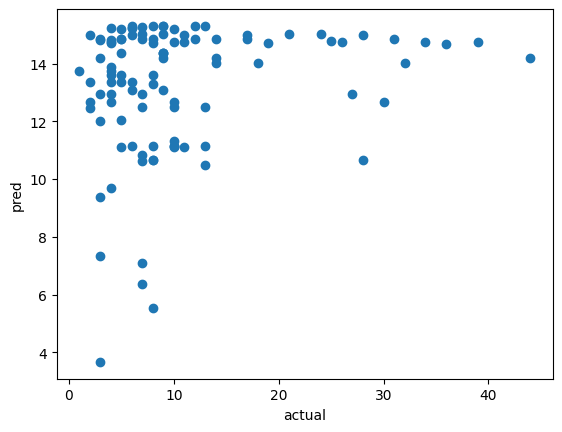

In [21]:
plt.scatter(gg.ndata['label'][405:].detach().numpy(), b.flatten().detach().numpy())
plt.ylabel("pred")
plt.xlabel("actual")
plt.show()

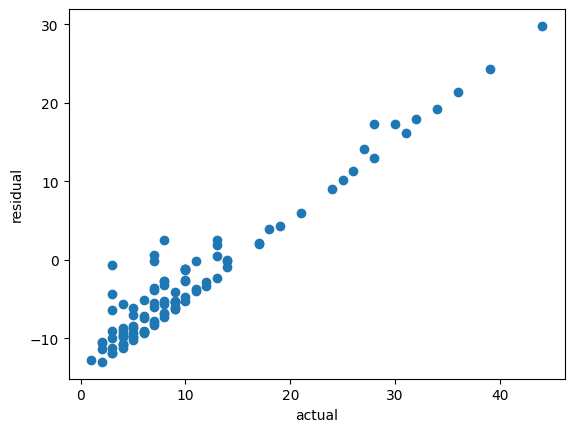

In [22]:
plt.scatter(gg.ndata['label'][405:].detach().numpy(),gg.ndata['label'][405:].detach().numpy()- b.flatten().detach().numpy())
plt.ylabel("residual")
plt.xlabel("actual")
plt.show()

In [23]:
#set up the regression model
#difference between hop and neighbors
def objective(trial):

  #model = GCN(43,10, 2)


  #num_layers=trial.suggest_int("num_layer", 1,3)
  hidden_size=trial.suggest_int("hidden_size",16,512)
  #dropout=trial.suggest_uniform("dropout",0.1,0.5)
  lr=trial.suggest_loguniform("learning_rate",1e-5,5e-1)
  optimizer_name=trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  best_val_acc = 0
  best_test_acc = 0
  model = GCN(43,hidden_size, 2)#,torch.tensor(dropout)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
  #g=GCN(43,hidden_size, 2)
  features = g.ndata["feat"]
  labels = g.ndata["label"]
      #print(f"Labels are: {labels}")
  train_mask = g.ndata["train_mask"]
      #print(f"Train_mask {train_mask}")
  val_mask = g.ndata["val_mask"]
  test_mask = g.ndata["test_mask"]
  for e in range(50):
        # Forward

        logits = model(g, features)
        #print(f"Prediction is {logits}")
        # Compute prediction
        #logits=g.ndata["feat"]
        pred = logits.argmax(dim=1)
        #print(pred[train_mask])
        #print(f"Prediction is {pred}")

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        #print(f"Data type {logits[train_mask].dtype}")
        #print(f"Data type {labels[train_mask].dtype}")
        loss = F.cross_entropy(logits[train_mask], labels[train_mask].to(torch.long))
        #print(f"Loss is {loss}")

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        trial.report(val_acc, e)
        if trial.should_prune():
          raise optuna.exceptions.TrialPruned()
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if e % 5 == 0:
         #   print(
           #     f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
          #  )

  return best_val_acc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
#print(trial.)

for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
model = GCN(43,10, 2)
#print(model)
#objective(g,model)

[I 2023-09-22 03:23:15,256] A new study created in memory with name: no-name-a93e0149-984e-440a-8eb2-695972d0ddb7
<ipython-input-23-75e851cf4b46>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr=trial.suggest_loguniform("learning_rate",1e-5,5e-1)
[I 2023-09-22 03:23:15,689] Trial 0 finished with value: 0.8011810779571533 and parameters: {'hidden_size': 152, 'learning_rate': 0.2766705481813047, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.8011810779571533.
[I 2023-09-22 03:23:16,076] Trial 1 finished with value: 1.0 and parameters: {'hidden_size': 75, 'learning_rate': 0.00010847808682374881, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 1.0.
[I 2023-09-22 03:23:16,581] Trial 2 finished with value: 0.8011810779571533 and parameters: {'hidden_size': 430, 'learning_rate': 0.18605302439346094, 'optimizer': 'RMSp

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  49
  Number of complete trials:  51
Best trial:
  Value:  1.0
    hidden_size: 75
    learning_rate: 0.00010847808682374881
    optimizer: RMSprop


In [24]:
optuna.importance.get_param_importances(study)

{'hidden_size': 0.7860293045182086,
 'learning_rate': 0.16970284159149743,
 'optimizer': 0.04426785389029396}

In [25]:
optuna.visualization.plot_param_importances(study)

In [28]:
#nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4.csv")
#print(nodes_data.shape)
#Attribute names
#print(nodes_data.columns)
#node_feat = nodes_data.drop(['id','Mean HLOS'], axis=1)

In [31]:
nodes_data

,id,admission_disposition,age,sex,Hypertension,Chronic cardiac disease (not hypertension),N/A,Diabetes,History of cancer [now in remission],Other,...,reason_for_admission_Pneumonia [J18.9],"reason_for_admission_Pneumonia due to 2019-nCoV [U07.1, J12.8]","reason_for_admission_Pneumonia due to COVID-19 virus [U07.1, J12.8]",reason_for_admission_Respiratory distress [R06.0],reason_for_admission_Respiratory failure [J96.99],reason_for_admission_Respiratory tract infection [J98.8],reason_for_admission_Shortness of breath [R06.0],"reason_for_admission_Shortness of breath with exposure to COVID-19 virus [R06.0, U07.2]",reason_for_admission_Suspected COVID-19 virus infection [U07.2],Mean HLOS
0,0,1,74,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,61,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,2,1,58,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,3,1,94,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,4,1,91,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,503,1,74,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
504,504,1,81,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
505,505,1,74,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
506,506,1,48,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
len(nodes_data.columns)

45

In [40]:
len(nodes_data)

508

In [89]:
from scipy.spatial.distance import cdist
nrows = len(nodes_data)
ncols= len(nodes_data.columns)
node_wo_label = nodes_data.drop(['Mean HLOS','id'], axis=1)
sim= cdist(node_wo_label, node_wo_label)

In [90]:
sim

array([[ 0.        , 13.11487705, 16.1245155 , ...,  1.41421356,
        26.0959767 ,  2.23606798],
       [13.11487705,  0.        ,  3.16227766, ..., 13.11487705,
        13.15294644, 12.20655562],
       [16.1245155 ,  3.16227766,  0.        , ..., 16.1245155 ,
        10.14889157, 15.13274595],
       ...,
       [ 1.41421356, 13.11487705, 16.1245155 , ...,  0.        ,
        26.05762844,  1.73205081],
       [26.0959767 , 13.15294644, 10.14889157, ..., 26.05762844,
         0.        , 25.01999201],
       [ 2.23606798, 12.20655562, 15.13274595, ...,  1.73205081,
        25.01999201,  0.        ]])

In [91]:
sim.mean()

18.906833617060904

In [92]:
df_st['Weight'].max()

18.33

In [51]:
test_mat= np.matrix([[0,7,2],[7,0,1],[2,1,0]])
test_mat

matrix([[0, 7, 2],
        [7, 0, 1],
        [2, 1, 0]])

In [62]:
test_mat.shape

(3, 3)

In [71]:
tar=[]
for row in range(test_mat.shape[0]):
  for col in range(test_mat.shape[1]):
    val = test_mat[row,col]
    if row!= col and val<3:
        tar.append([row, col,val])
tar

[[0, 2, 2], [1, 2, 1], [2, 0, 2], [2, 1, 1]]

In [68]:
test_mat[0,1]

7

In [75]:
oh=test_mat<3
oh

matrix([[ True, False,  True],
        [False,  True,  True],
        [ True,  True,  True]])

In [156]:
def get_sim(mat, att):
  result = []
  for row in range(mat.shape[0]):
    for col in range(mat.shape[1]):
      val = mat[row,col]
      if row!= col and val<att:
          result.append([row, col,val])
  result=np.array(result)
  result_tp = result.transpose()
  df = pd.DataFrame({'Src':result_tp[0],
                    'Dst': result_tp[1],
                    'Weight': result_tp[2]
                    })
  df=df.astype({"Src":'int64'})
  df=df.astype({"Dst":'int64'})
  return df


In [94]:
df_my_st=get_sim(sim,sim.mean())

In [95]:
df_my_st

,Src,Dst,Weight
0,0.0,1.0,13.114877
1,0.0,2.0,16.124515
2,0.0,4.0,17.058722
3,0.0,7.0,3.162278
4,0.0,8.0,18.027756
...,...,...,...
145627,507.0,501.0,5.567764
145628,507.0,502.0,17.117243
145629,507.0,503.0,2.236068
145630,507.0,504.0,8.246211


In [45]:
df_st = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/someTest.csv")
df_st

,Src,Dst,Weight
0,0,1,13.1150
1,0,2,16.1250
2,0,4,17.0590
3,0,7,3.1623
4,0,8,18.0280
...,...,...,...
145593,507,501,5.5678
145594,507,502,17.1170
145595,507,503,2.2361
145596,507,504,8.2462


In [147]:
df_st['Dst'].dtype

dtype('int64')

In [150]:
df_my_st=df_my_st.astype({"Src":'int64'})
df_my_st=df_my_st.astype({"Dst":'int64'})
df_my_st

,Src,Dst,Weight
0,0,1,13.114877
1,0,2,16.124515
2,0,4,17.058722
3,0,7,3.162278
4,0,8,18.027756
...,...,...,...
145627,507,501,5.567764
145628,507,502,17.117243
145629,507,503,2.236068
145630,507,504,8.246211


(array([[158., 159., 109., ...,   0.,   0.,   0.],
        [161., 159.,  96., ...,   0.,   0.,   0.],
        [159., 145., 104., ...,   0.,   0.,   0.],
        ...,
        [160., 157., 109., ...,   0.,   0.,   0.],
        [ 91., 132.,  84., ...,   0.,   0.,   0.],
        [159., 163., 110., ...,   0.,   0.,   0.]]),
 array([ 0.        ,  8.10370286, 16.20740571, 24.31110857, 32.41481143,
        40.51851429, 48.62221714, 56.72592   , 64.82962286, 72.93332572,
        81.03702857]),
 <a list of 508 BarContainer objects>)

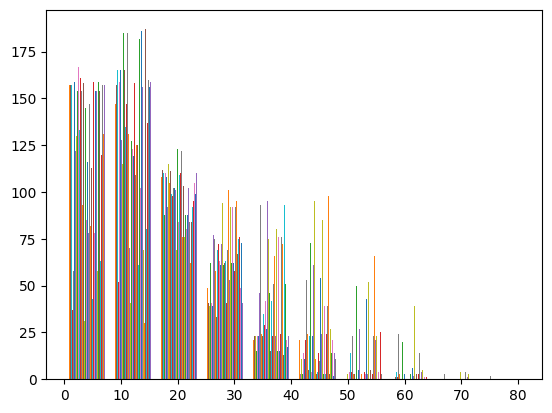

In [96]:
plt.hist(sim)

In [98]:
np.percentile(sim,5)

2.6457513110645907

In [188]:
df_st_05=get_sim(sim,np.percentile(sim,5))

In [189]:
df_st_05

,Src,Dst,Weight
0,0,8,2.431154
1,0,15,3.529377
2,0,213,2.647564
3,0,234,2.949610
4,0,245,3.468401
...,...,...,...
12385,507,343,2.939076
12386,507,345,3.523360
12387,507,381,2.656917
12388,507,505,3.422533


In [154]:
class CarePathwaysDataset_me(DGLDataset):

        def __init__(self,edges_data):
          self.edges_data=edges_data
          super().__init__(name="care_pthways")
          #self.edges_data=edges_data

        def process(self):
          nodes_data = pd.read_csv("/content/drive/MyDrive/healthcare_gnn/pt_pathways-v4.csv")
          #print(nodes_data.shape)
          #Attribute names
          #print(nodes_data.columns)
          node_feat = nodes_data.drop(['id','Mean HLOS'], axis=1)
          #print(f"Node Features Dimension {node_feat.shape}")
          tsr_feat = torch. tensor(node_feat.values)
          torch.save(tsr_feat, 'data.pt')

          #edges_data = pd.read_csv("/content/drive/MyDrive/CarePathways/someTest.csv")
          edges_data = self.edges_data
          #node_features = torch.from_numpy(nodes_data["age"].to_numpy())
          node_features = tsr_feat
          node_labels = torch.from_numpy(nodes_data["Mean HLOS"].astype(float).to_numpy())
          edge_features = torch.from_numpy(edges_data["Weight"].to_numpy())
          edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
          edges_dst = torch.from_numpy(edges_data["Dst"].to_numpy())

          self.graph = dgl.graph((edges_src, edges_dst),num_nodes=nodes_data.shape[0])
          self.graph.ndata["feat"] = node_features
          self.graph.ndata["label"] = node_labels
          self.graph.edata["weight"] = edge_features

           # If your dataset is a node classification dataset, you will need to assign
          # masks indicating whether a node belongs to training, validation, and test set.
          n_nodes = nodes_data.shape[0]
          n_train = int(n_nodes * 0.6)
          #train_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTrainInd.csv")
          n_val = int(n_nodes * 0.2)
          #val_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptValidInd.csv")
          n_test = 100
          #test_inst = pd.read_csv("/content/drive/MyDrive/CarePathways/ptTestInd.csv")
          train_mask = torch.zeros(n_nodes, dtype=torch.int)
          val_mask = torch.zeros(n_nodes, dtype=torch.int)
          test_mask = torch.zeros(n_nodes, dtype=torch.int)
          train_mask[:n_train] = int(1)
          val_mask[n_train : n_train + n_val] = int(1)
          test_mask[n_train + n_val :] = int(1)
          self.graph.ndata["train_mask"] = train_mask
          self.graph.ndata["val_mask"] = val_mask
          self.graph.ndata["test_mask"] = test_mask

        def __getitem__(self, i):
          return self.graph

        def __len__(self):
          return 1

In [126]:
dset=CarePathwaysDataset_me(df_st)

(508, 45)
Index(['id', 'admission_disposition', 'age', 'sex', 'Hypertension',
       'Chronic cardiac disease (not hypertension)', 'N/A', 'Diabetes',
       'History of cancer [now in remission]', 'Other', 'Kidney disease',
       'Obesity', 'Asthma', 'Rheumatologic disorder',
       'Dementia [any etiology]', 'Chronic pulmonary (lung) disease',
       'Pregnancy', 'Stroke', 'Cancer [active only]', 'Liver disease',
       'Chronic renal', 'Chronic neurological disorder', 'Hematological',
       'reason_for_admission_ARDS (adult respiratory distress syndrome) [J80]',
       'reason_for_admission_Acquired respiratory distress syndrome [J80]',
       'reason_for_admission_COVID-19 [U07.1]',
       'reason_for_admission_COVID-19 determined by clinical diagnostic criteria [U07.2]',
       'reason_for_admission_COVID-19 virus infection [U07.1]',
       'reason_for_admission_COVID-19 with multiple comorbidities [U07.1]',
       'reason_for_admission_Coronavirus infection [B34.2]',
       'rea

In [213]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes,):
        super(GCN, self).__init__()
        self.allow_zero_in_degree=True #oh no
        allow_zero_in_degree=True
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        #self.dropout = dropout

    def forward(self, g, in_feat):
        self.allow_zero_in_degree = True
        allow_zero_in_degree=True
        h = self.conv1(g, in_feat)
        h = F.relu(h) #relu
        #h=F.dropout(self.dropout)
        h = self.conv2(g, h)
        #m=nn.Linear(h.shape[1],h.shape[1]) #for regression
        #h=m(h)
        return h

# Create the model with given dimensions
print(g.ndata["feat"].shape)
model = GCN(g.ndata["feat"].shape[1], 10, 2)
print(model)

torch.Size([508, 43])
GCN(
  (conv1): GraphConv(in=43, out=10, normalization=both, activation=None)
  (conv2): GraphConv(in=10, out=2, normalization=both, activation=None)
)


In [214]:
nani=CarePathwaysDataset_me(df_st_05)
nani=nani[0]
nani=dgl.add_self_loop(nani)
m=GCN(43,32,2)
train(nani,m)

In epoch 0, loss: 5.371, val acc: 0.801 (best 0.801), test acc: 0.797 (best 0.797)
In epoch 25, loss: 0.920, val acc: 0.801 (best 0.801), test acc: 0.797 (best 0.797)
In epoch 50, loss: 0.639, val acc: 0.199 (best 1.000), test acc: 0.203 (best 1.000)
In epoch 75, loss: 0.576, val acc: 1.000 (best 1.000), test acc: 1.000 (best 1.000)


(tensor(1.), tensor(1.))

In [215]:
sim= cdist(node_wo_label, node_wo_label, 'mahalanobis')

In [216]:
def dist_quantile(node_df, dist_array, p_array):
  #sim= cdist(node_wo_label, node_wo_label)
  #df_st=get_sim(sim,np.percentile(sim,5))
  result = []
  for dt in dist_array:
    for percentile in p_array:
      print([dt, percentile])
      sim = cdist(node_wo_label, node_wo_label, dt)
      df_st = get_sim(sim,np.percentile(sim,percentile))
      data = CarePathwaysDataset_me(df_st)[0]
      data = dgl.add_self_loop(data)
      model = GCN(43,32,2)
      #model = model.add_self_loop(model)
      result.append([dt, percentile, train(data,model)])
  result=np.array(result)
  result_tp = result.transpose()
  df = pd.DataFrame({'Distance Metric':result_tp[0],
                    'Percentile': result_tp[1],
                    'Test_Val': result_tp[2]
                    })

  return result

In [211]:
d_array = ['cityblock','euclidean','cosine','mahalanobis']
p_array=[0.5,5,10,25]

In [217]:
dist_quantile(node_wo_label, d_array, p_array)

['cityblock', 0.5]
In epoch 0, loss: 1.921, val acc: 0.801 (best 0.801), test acc: 0.797 (best 0.797)
In epoch 25, loss: 0.460, val acc: 1.000 (best 1.000), test acc: 1.000 (best 1.000)
In epoch 50, loss: 0.340, val acc: 1.000 (best 1.000), test acc: 1.000 (best 1.000)
In epoch 75, loss: 0.241, val acc: 1.000 (best 1.000), test acc: 1.000 (best 1.000)
['cityblock', 5]
In epoch 0, loss: 2.801, val acc: 0.801 (best 0.801), test acc: 0.797 (best 0.797)
In epoch 25, loss: 0.659, val acc: 0.199 (best 1.000), test acc: 0.203 (best 1.000)
In epoch 50, loss: 0.635, val acc: 0.199 (best 1.000), test acc: 0.203 (best 1.000)
In epoch 75, loss: 0.608, val acc: 1.000 (best 1.000), test acc: 1.000 (best 1.000)
['cityblock', 10]
In epoch 0, loss: 2.767, val acc: 0.801 (best 0.801), test acc: 0.797 (best 0.797)
In epoch 25, loss: 0.733, val acc: 0.199 (best 0.801), test acc: 0.203 (best 0.797)
In epoch 50, loss: 0.653, val acc: 1.000 (best 1.000), test acc: 1.000 (best 1.000)
In epoch 75, loss: 0.620,

<ipython-input-216-48c3e20b70a8>:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



array([['cityblock', 0.5, (tensor(1.), tensor(1.))],
       ['cityblock', 5, (tensor(1.), tensor(1.))],
       ['cityblock', 10, (tensor(1.), tensor(1.))],
       ['cityblock', 25, (tensor(1.), tensor(1.))],
       ['euclidean', 0.5, (tensor(1.), tensor(1.))],
       ['euclidean', 5, (tensor(1.), tensor(1.))],
       ['euclidean', 10, (tensor(1.), tensor(1.))],
       ['euclidean', 25, (tensor(1.), tensor(1.))],
       ['cosine', 0.5, (tensor(1.), tensor(1.))],
       ['cosine', 5, (tensor(1.), tensor(1.))],
       ['cosine', 10, (tensor(1.), tensor(1.))],
       ['cosine', 25, (tensor(0.8012), tensor(0.7972))],
       ['mahalanobis', 0.5, (tensor(1.), tensor(1.))],
       ['mahalanobis', 5, (tensor(1.), tensor(1.))],
       ['mahalanobis', 10, (tensor(1.), tensor(1.))],
       ['mahalanobis', 25, (tensor(0.8012), tensor(0.7972))]],
      dtype=object)